In [40]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [64]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = '/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/Dataset_Train_Test/'
data_dir_train = os.path.join(data_dir, 'Train')
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'Test')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 360
NUM_TEST = 100

NUM_OF_EPOCHS = 10

In [65]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)

    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)

    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [66]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 563 images belonging to 1 classes.
Found 563 images belonging to 1 classes.
Found 141 images belonging to 1 classes.
Found 141 images belonging to 1 classes.


In [67]:
def display(display_list):
    plt.figure(figsize=(30,30))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [68]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

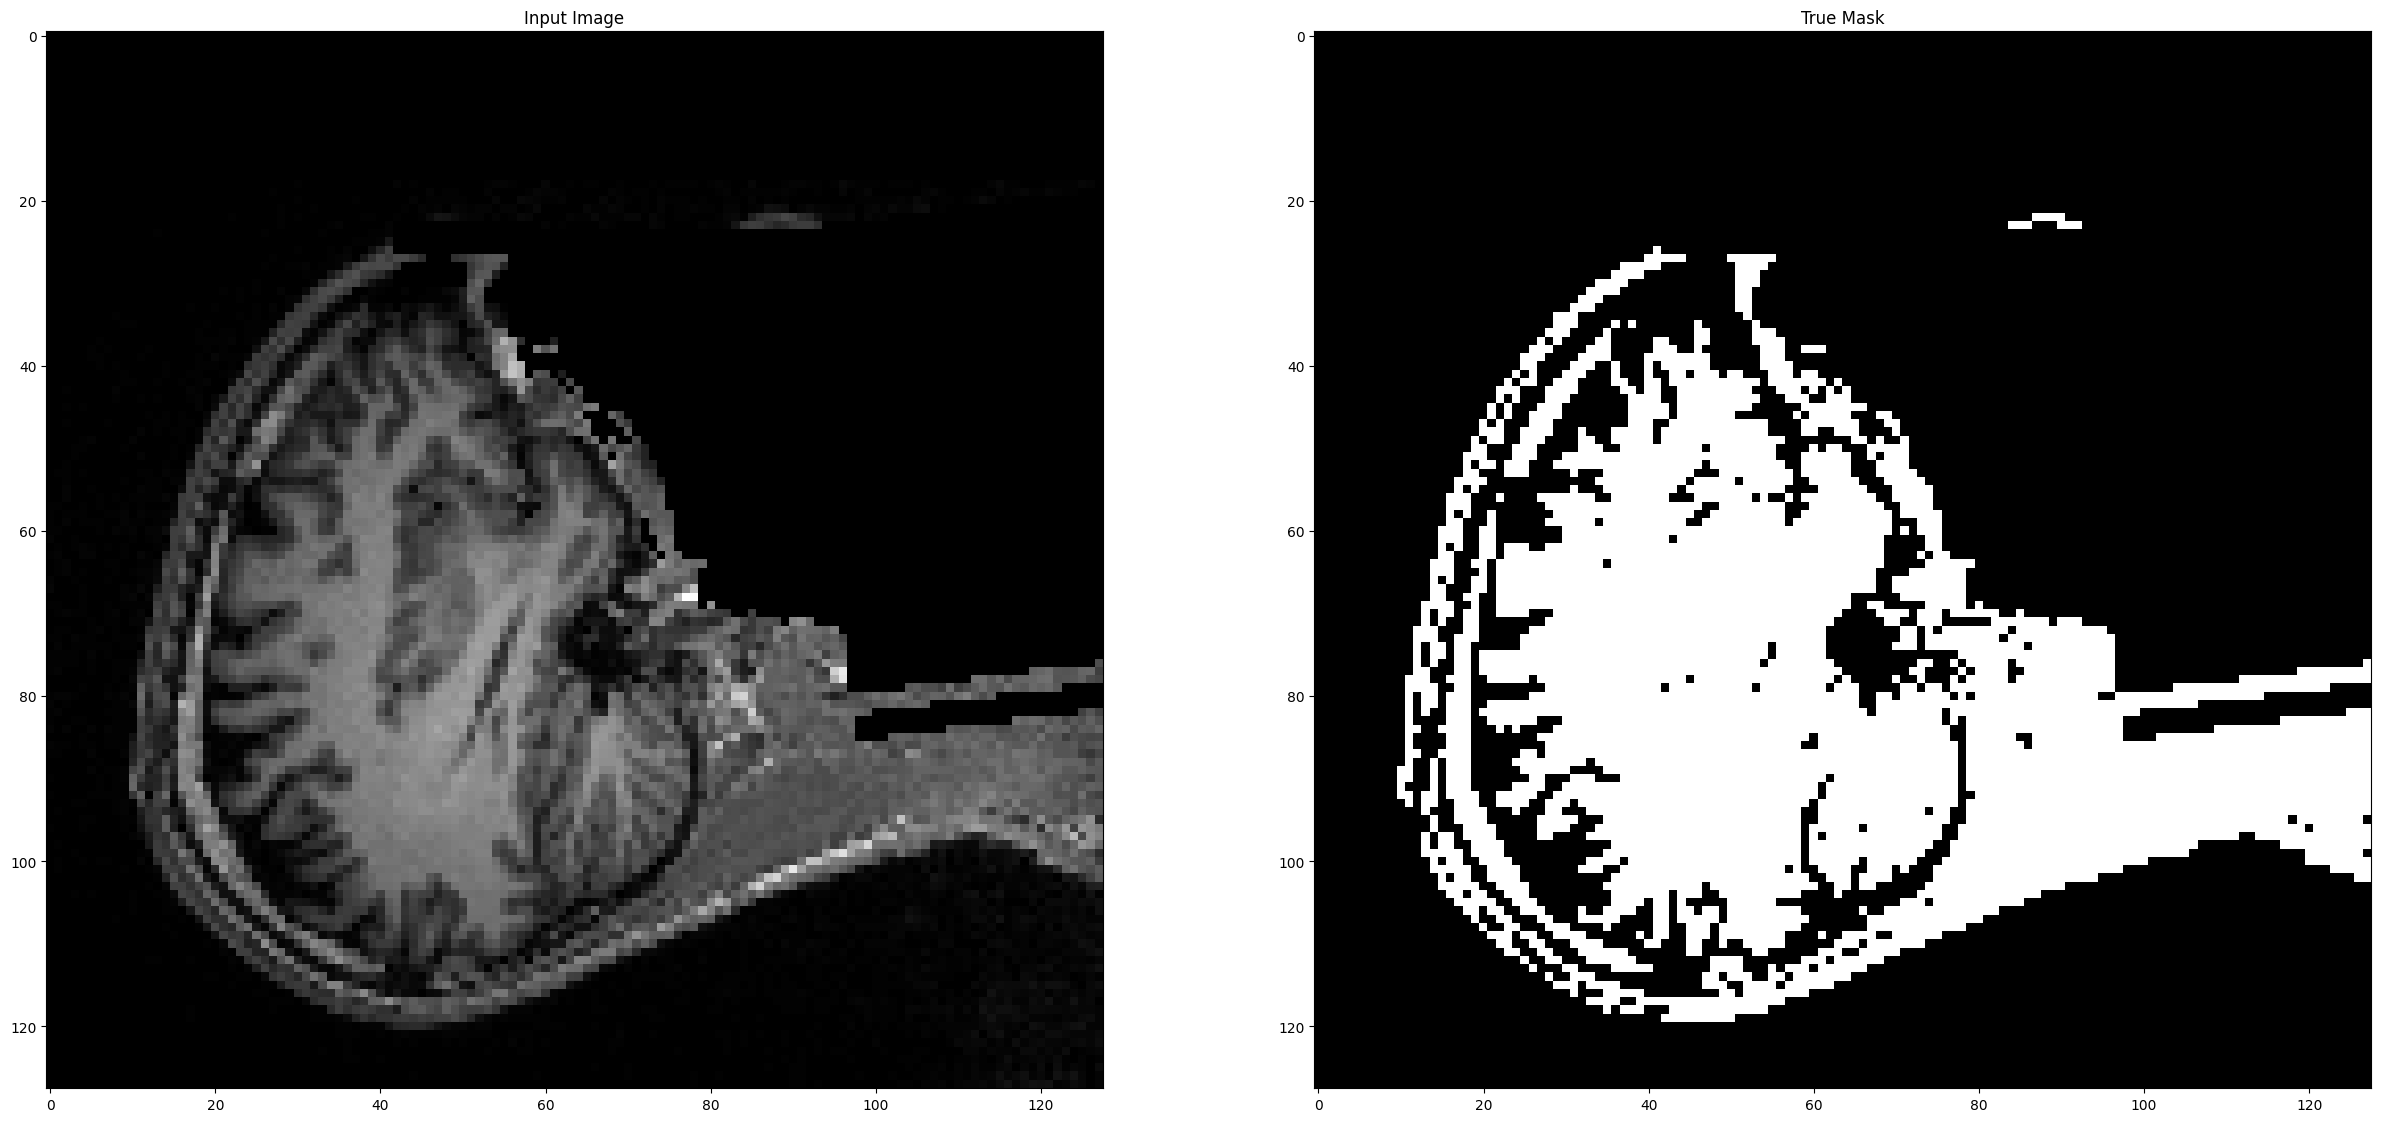

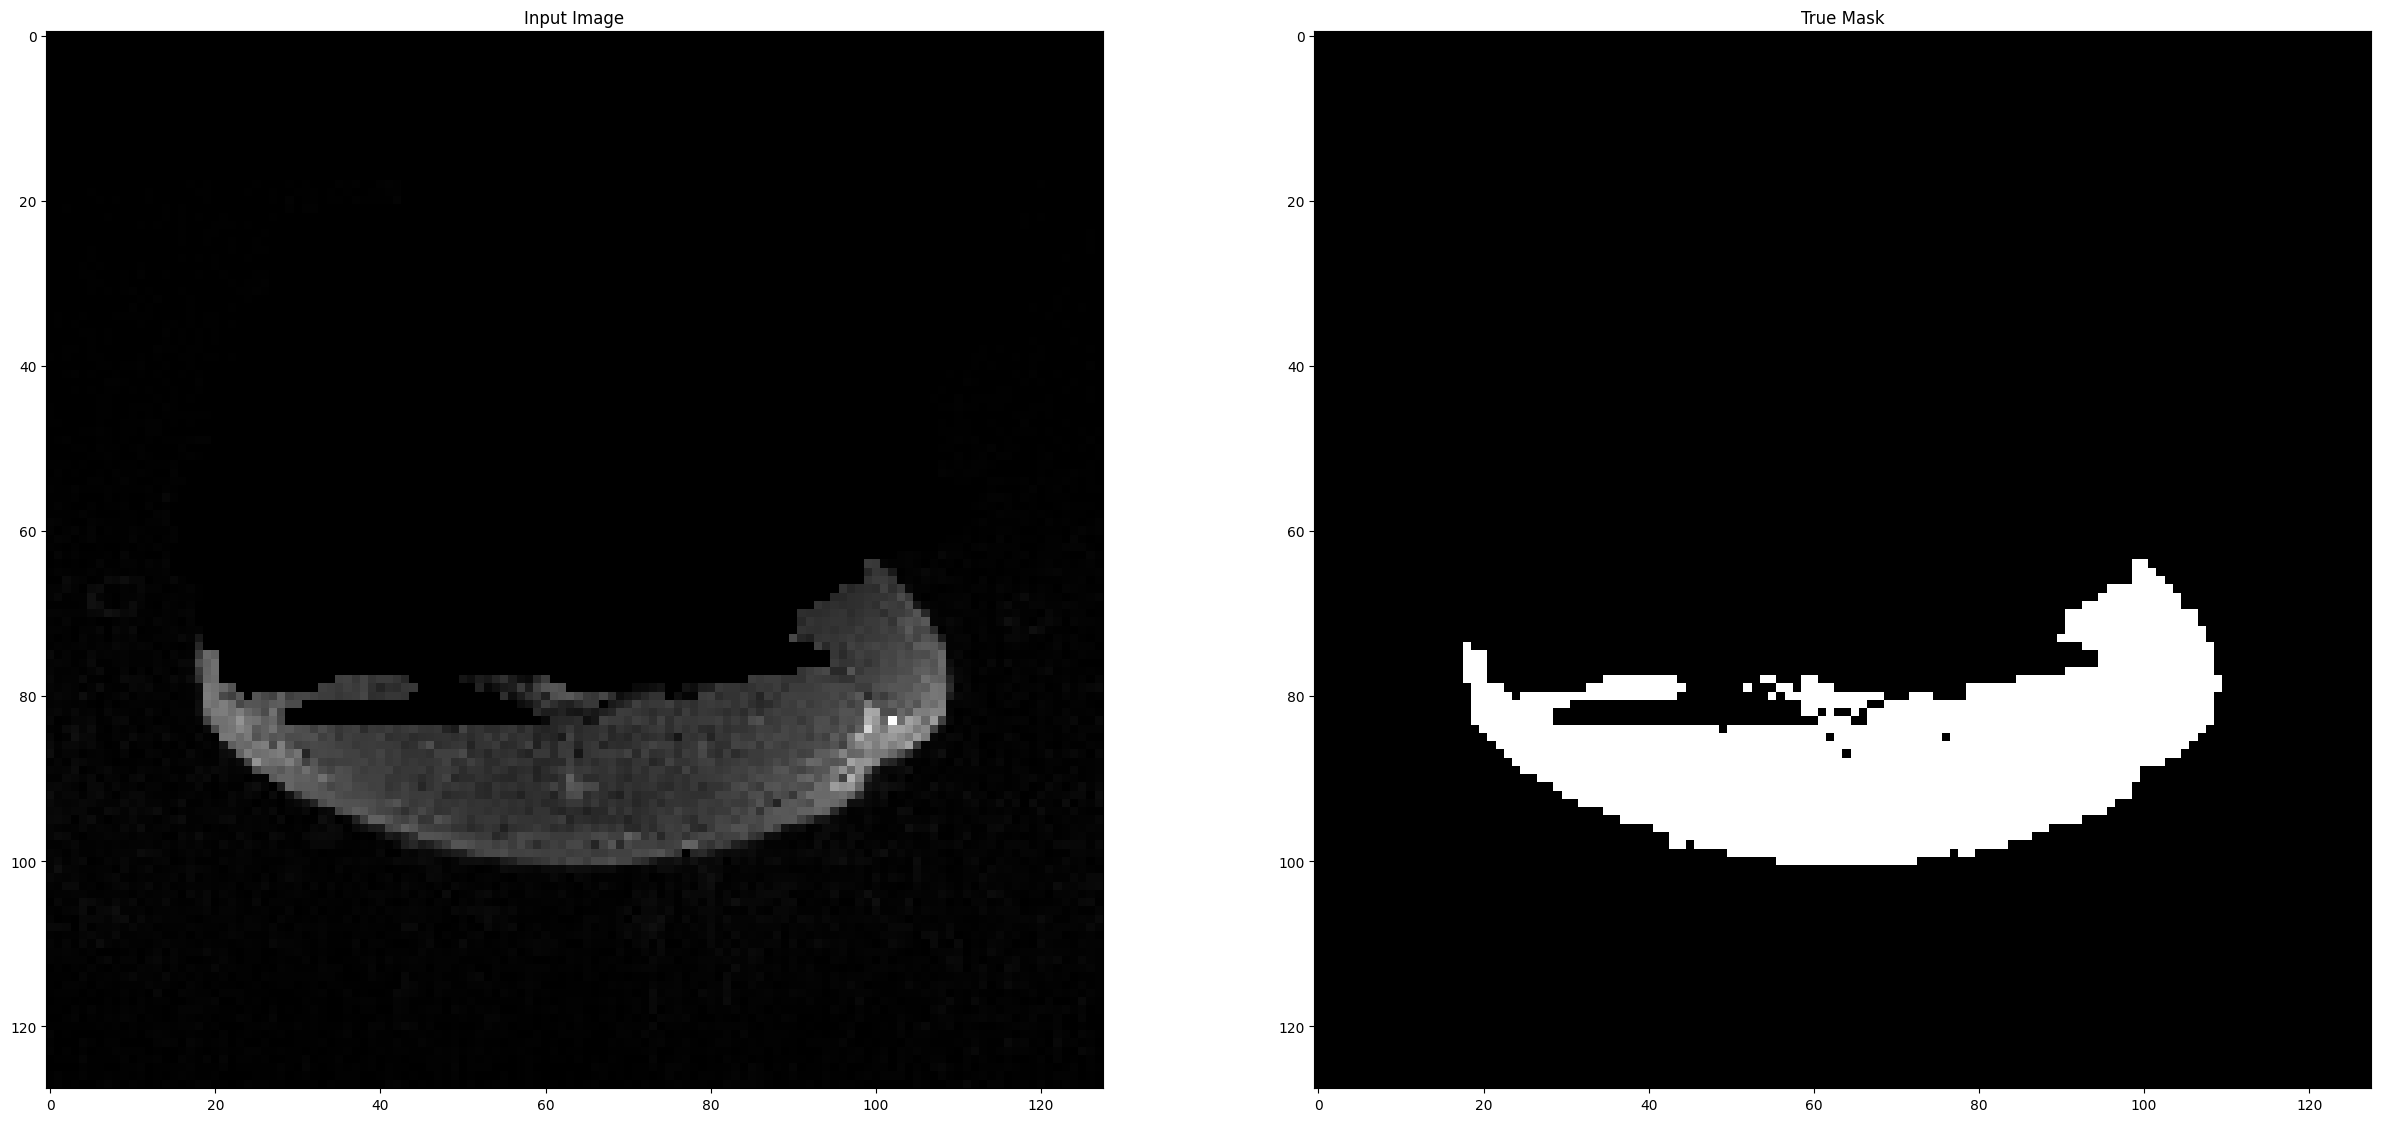

In [69]:
show_dataset(train_generator, 2)


In [70]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs

    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')

    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)

    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)

    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)

    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')


In [71]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
model.summary()


Model: "UNET-L4-F32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_91 (Conv2D)             (None, 128, 128, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_92 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_91[0][0]']              
                                )                                                       

In [73]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=EPOCH_STEP_TRAIN,
                    validation_data=test_generator,
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

Epoch 1/10


<ipython-input-73-f52164cccefe>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


11/11 [==============================] - 14s 324ms/step - loss: 0.5669 - accuracy: 0.8294 - val_loss: 0.2537 - val_accuracy: 0.9281
Epoch 2/10
11/11 [==============================] - 6s 594ms/step - loss: 0.1924 - accuracy: 0.9167 - val_loss: 0.1974 - val_accuracy: 0.9168
Epoch 3/10
11/11 [==============================] - 2s 195ms/step - loss: 0.1382 - accuracy: 0.9377 - val_loss: 0.1181 - val_accuracy: 0.9553
Epoch 4/10
11/11 [==============================] - 2s 194ms/step - loss: 0.1021 - accuracy: 0.9566 - val_loss: 0.0847 - val_accuracy: 0.9641
Epoch 5/10
11/11 [==============================] - 3s 240ms/step - loss: 0.0779 - accuracy: 0.9667 - val_loss: 0.0749 - val_accuracy: 0.9673
Epoch 6/10
11/11 [==============================] - 2s 236ms/step - loss: 0.0674 - accuracy: 0.9710 - val_loss: 0.0706 - val_accuracy: 0.9697
Epoch 7/10
11/11 [==============================] - 2s 194ms/step - loss: 0.0631 - accuracy: 0.9734 - val_loss: 0.0595 - val_accuracy: 0.9754
Epoch 8/10
11/11

In [74]:
model.save(f'/content/drive/MyDrive/Internship 2023/Skull Strip based on deep learning/Trained model/UNET-BrainSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')


In [75]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)


Found 141 images belonging to 1 classes.
Found 141 images belonging to 1 classes.


In [76]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

1/1 [==============================] - 1s 697ms/step


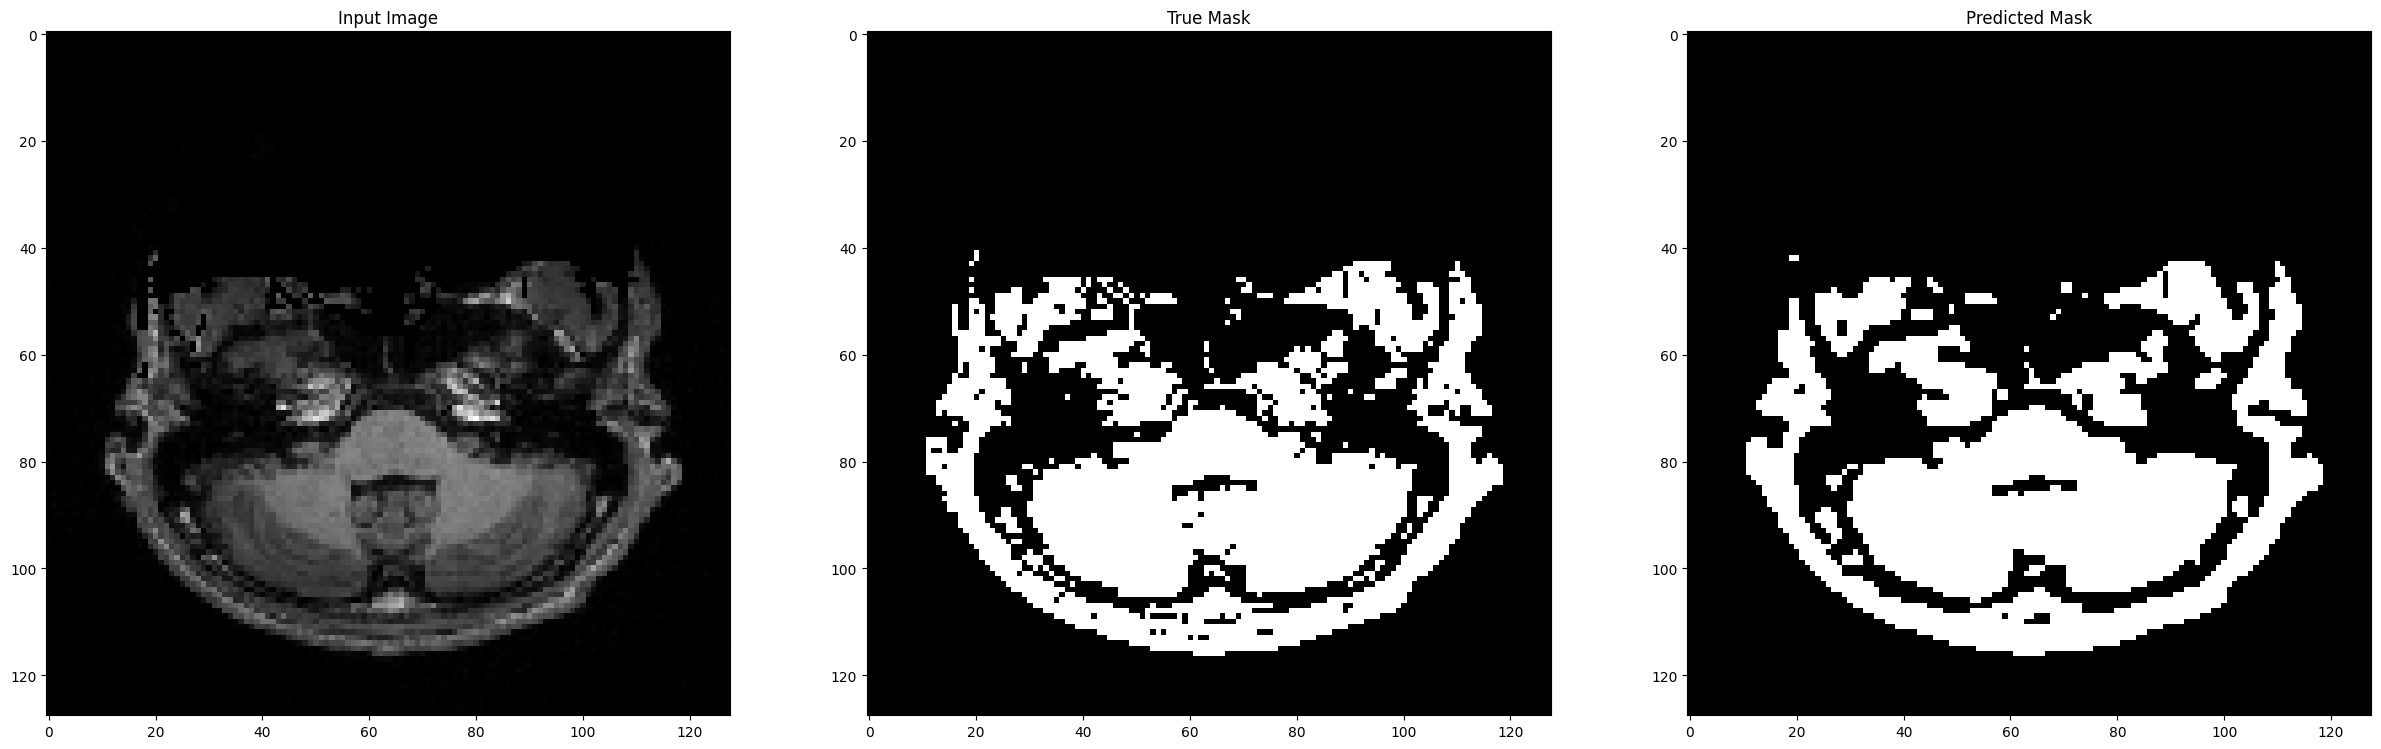

1/1 [==============================] - 0s 35ms/step


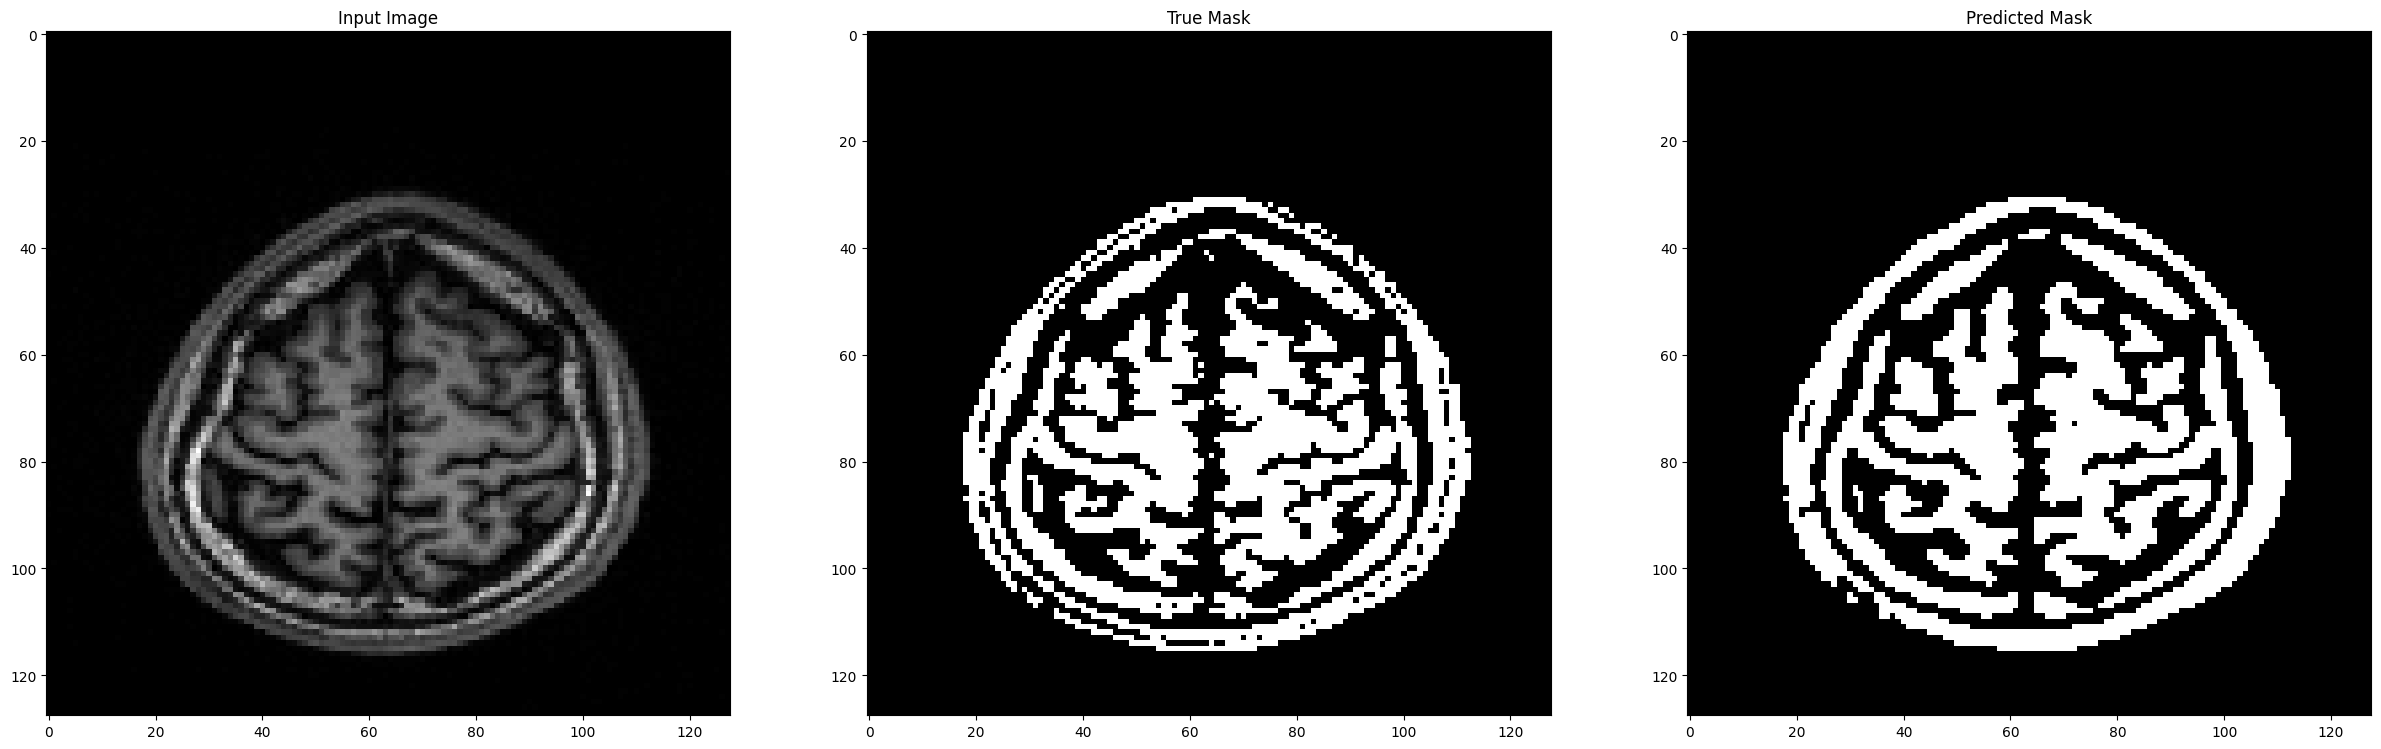

1/1 [==============================] - 0s 22ms/step


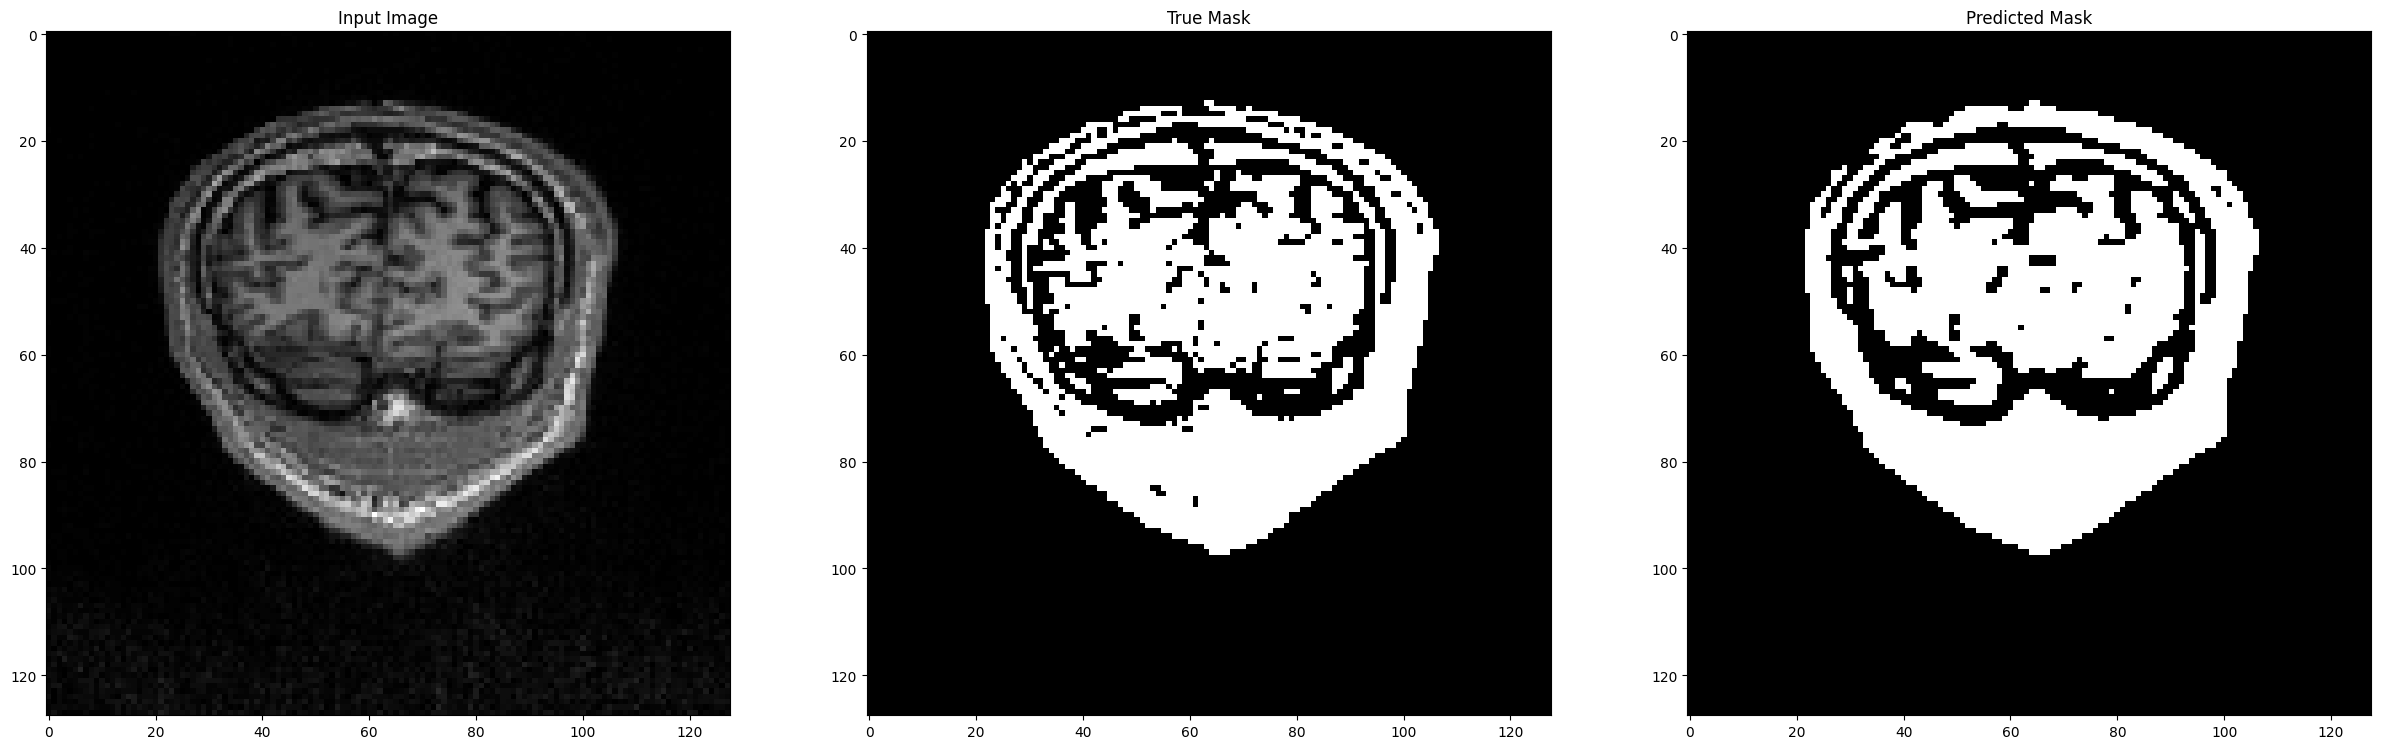

In [77]:
show_prediction(test_generator, 3)
